<a href="https://colab.research.google.com/github/inyong37/Study/blob/master/_Library/Keras/Keras_Example_FSL_Reptile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Title: Few-Shot learning with Reptile
# Re-Author: Inyong Hwang
# Date: 2022-01-07-Fri.
# Refernce: https://keras.io/examples/vision/reptile/
# Date #2: 2022-01-21-Fri.

# Introduction
The Reptile algorithm was developed by OpenAI to perform model agnostic meta-learning. Specifically, this algorithm was designed to quickly learn to perform new tasks with minimal training (few-shot learning). The algorithm works by performing Stochastic Gradient Descent using the difference between weights trained on a mini-batch of never before seen data and the model weights prior to training over a fixed number of meta-iterations.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [ ]:
# Define the Hyperparameters
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 2000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 5

# Prepare the data
The Omniglot dataset is a dataset of 1,623 characters taken from 50 different alphabets, with 20 examples of each character. The 20 samples for each character were drawn online via Amazon's Mechanical Turk. For the few-shot learning task, k samples (or "shots") are drawn randomly from n randomly-chosen classes. These n numerical values are used to create a new set of temporary labels to use to test the model's ability to learn a new task given few exmaples. In other words, if you are training on 5 classes, your new class labels will be either 0, 1, 2, 3, or 4. Omniglot is a great dataset for this task since there are many different classes to draw from, with a reasonable number of samples for each class.

In [ ]:
class Dataset:
  # This class will facilitate the creation of a few-shot dataset
  # from the Omniglot dataset that can be sampled from quickly while also
  # allowing to create new labels at the same time.
  def __init__(self, training):
    # Download the tfrecord files containing the omniglot data and covert to a
    # dataset.
    split = "train" if training else "test"
    ds = tfds.load("omniglot", split=split, as_supervised=True, shuffle_files=False)
    # Iterate over the dataset to get each individual image and its class,
    # and put that data into a dictionary.
    self.data = {}

    def  extraction(image, label):
      # This function will shrink the Omniglot images to the desired size,
      # scale pixel values and convert the RGB image to grayscale
      image = tf.image.convert_image_dtype(image, tf.float32)
      image = tf.image.rgb_to_grayscale(image)
      image = tf.image.resize(image, [28, 28])
      return image, label
    
    for image, label in ds.map(extraction):
      image = image.numpy()
      label = str(label.numpy())
      if label not in self.data:
        self.data[label] = []
      self.data[label].append(image)
    self.labels = list(self.data.keys())
  
  def get_mini_dataset(
      self, batch_size, repetitions, shots, num_classes, split=False
  ):
    temp_labels = np.zeros(shape=(num_classes * shots))
    temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
    if split:
      test_labels = np.zeros(shape=(num_classes))
      test_images = np.zeros(shape=(num_classes, 28, 28, 1))
    
    # Get a random subset of labels from the entire label set.
    label_subset = random.choices(self.labels, k=num_classes)
    for class_idx, class_obj in enumerate(label_subset):
      # Use enumerated index value as a temporary label for mini-batch in
      # few shot learning
      temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
      # If creating a split dataset for testing, select an extra example from each
      # label to create the test dataset.
      if split:
        test_labels[class_idx] = class_idx
        images_to_split = random.choices(
          self.data[label_subset[class_idx]], k=shots + 1
        )
        test_images[class_idx] = images_to_split[-1]
        temp_images[
          class_idx * shots : (class_idx + 1) * shots
        ] = images_to_split[:-1]
      else:
        # For each index in the randomly selected label_subset, sample the
        # necessary number of images.
        temp_images[
          class_idx * shots : (class_idx + 1) * shots
        ] = random.choices(self.data[label_subset[class_idx]], k=shots)

    dataset = tf.data.Dataset.from_tensor_slices(
      (temp_images.astype(np.float32), temp_labels.astype(np.int32))
    )
    dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
    if split:
      return dataset, test_images, test_labels
    return dataset


import urllib3

urllib3.disable_warnings() # Disable SSL warnings that my happen during download.
train_dataset = Dataset(training=True)
test_dataset = Dataset(training=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/omniglot/3.0.0.incompleteVM4C6H/omniglot-train.tfrecord


  0%|          | 0/19280 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/omniglot/3.0.0.incompleteVM4C6H/omniglot-test.tfrecord


  0%|          | 0/13180 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/omniglot/3.0.0.incompleteVM4C6H/omniglot-small1.tfrecord


  0%|          | 0/2720 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/omniglot/3.0.0.incompleteVM4C6H/omniglot-small2.tfrecord


  0%|          | 0/3120 [00:00<?, ? examples/s]

Dataset omniglot downloaded and prepared to /root/tensorflow_datasets/omniglot/3.0.0. Subsequent calls will reuse this data.


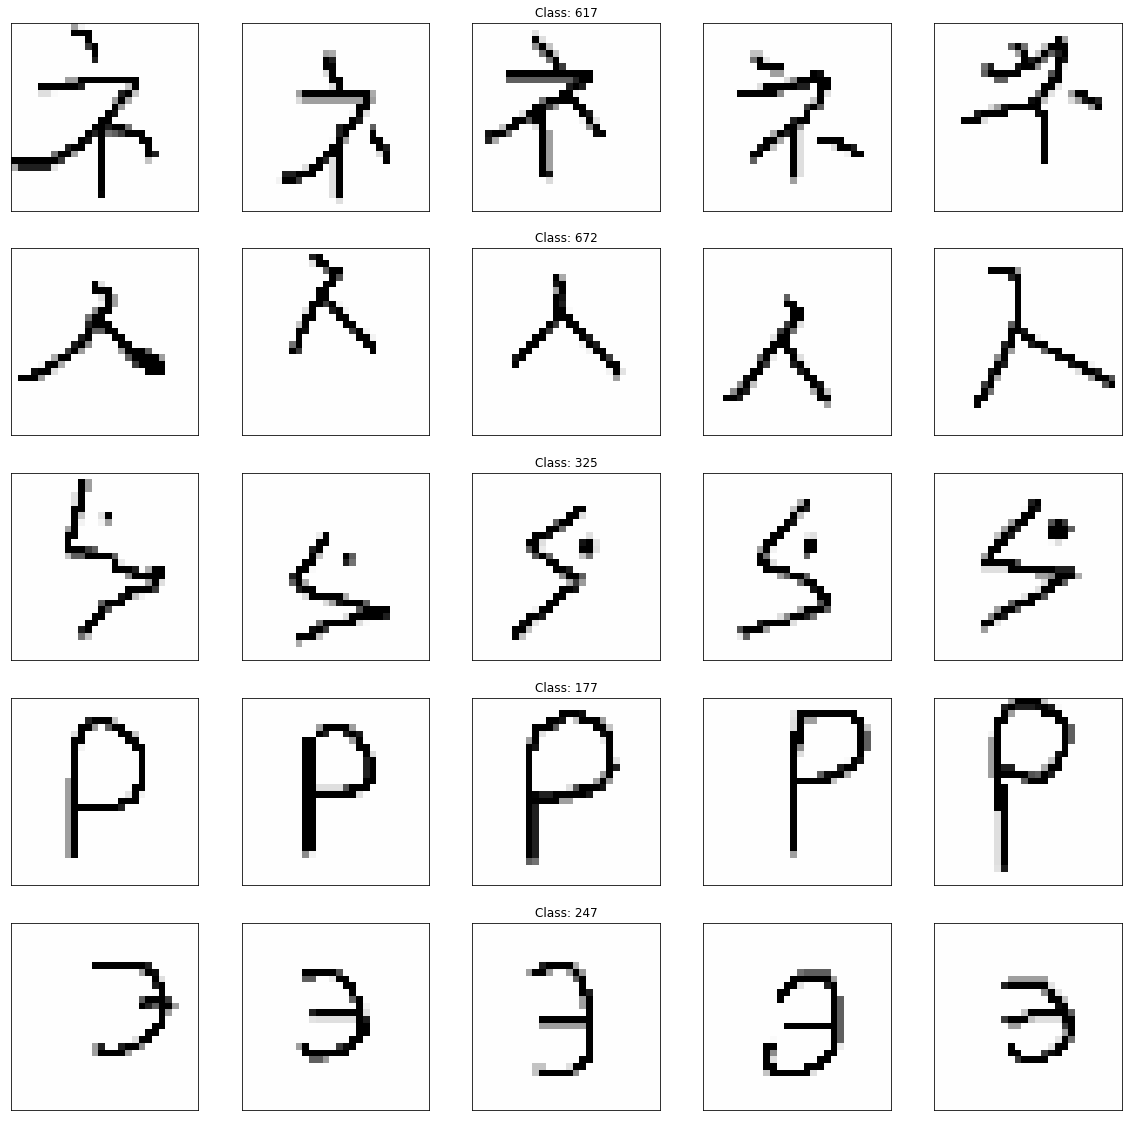

In [ ]:
# Visualize some examples from the dataset
_, axarr = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for a in range(5):
  for b in range(5):
    temp_image = train_dataset.data[sample_keys[a]][b]
    temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    if b == 2:
      axarr[a, b].set_title("Class: " + sample_keys[a])
    axarr[a, b].imshow(temp_image, cmap="gray")
    axarr[a, b].xaxis.set_visible(False)
    axarr[a, b].yaxis.set_visible(False)
plt.show()

In [ ]:
# Build the model
def conv_bn(x):
  x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  return layers.ReLU()(x)

inputs = layers.Input(shape=(28, 28, 1))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)
x = layers.Flatten()(x)
outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile()
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

In [ ]:
# Train the model
training = []
testing = []
for meta_iter in range(meta_iters):
  frac_done = meta_iter / meta_iters
  cur_meta_step_size = (1 - frac_done) * meta_step_size
  # Temporarily save the weights from the model.
  old_vars = model.get_weights()
  # Get a sample from the full dataset.
  mini_dataset = train_dataset.get_mini_dataset(
      inner_batch_size, inner_iters, train_shots, classes
  )
  for images, labels in mini_dataset:
    with tf.GradientTape() as tape:
      preds = model(images)
      loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
  new_vars = model.get_weights()
  # Perform SGD for the meta step.
  for var in range(len(new_vars)):
    new_vars[var] = old_vars[var] + (
        (new_vars[var] - old_vars[var]) * cur_meta_step_size
    )
  # After the meta-learning step, reload the newly-trained weights into the model.
  model.set_weights(new_vars)
  # Evaluation loop
  if meta_iter % eval_interval == 0:
    accuracies = []
    for dataset in (train_dataset, test_dataset):
      # Sample a mini dataset from the full dataset.
      train_set, test_images, test_labels = dataset.get_mini_dataset(
          eval_batch_size, eval_iters, shots, classes, split=True
      )
      old_vars = model.get_weights()
      # Train on the samples and get the resulting accuracies.
      for images, labels in train_set:
        with tf.GradientTape() as tape:
          preds = model(images)
          loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
      test_preds = model.predict(test_images)
      test_preds = tf.argmax(test_preds).numpy()
      num_correct = (test_preds == test_labels).sum()
      # Reset the weights after getting hte evaluation accuracies.
      model.set_weights(old_vars)
      accuracies.append(num_correct / classes)
    training.append(accuracies[0])
    testing.append(accuracies[1])
    if meta_iter % 100 == 0:
      print(
          "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
      )

batch 0: train=0.400000 test=0.400000
batch 100: train=0.600000 test=0.600000
batch 200: train=1.000000 test=1.000000
batch 300: train=1.000000 test=1.000000
batch 400: train=1.000000 test=1.000000
batch 500: train=0.600000 test=0.800000
batch 600: train=1.000000 test=0.600000
batch 700: train=1.000000 test=1.000000
batch 800: train=1.000000 test=1.000000
batch 900: train=1.000000 test=1.000000
batch 1000: train=1.000000 test=0.800000
batch 1100: train=0.600000 test=1.000000
batch 1200: train=1.000000 test=0.800000
batch 1300: train=0.800000 test=1.000000
batch 1400: train=1.000000 test=1.000000
batch 1500: train=1.000000 test=0.600000
batch 1600: train=0.200000 test=0.800000
batch 1700: train=1.000000 test=0.600000
batch 1800: train=0.800000 test=1.000000
batch 1900: train=1.000000 test=0.800000


In [ ]:
# First, some preprocessing to smooth the training and testing arrays for display.
window_length = 100
train_s = np.r_[
  training[window_length - 1: 0 : -1], training, training[-1:-window_length:-1]
]
test_s = np.r_[
  testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# Display the training accuracies.
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(["test", "train"])
plt.grid()

train_set, test_images, test_labels = dataset.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
  with tf.GradientTape() as tape:
    preds = model(images)
    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
  grads = tape.gradient(loss, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

_, axarr = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(5), axarr):
  temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
  temp_image *= 255
  temp_iamge = np.clip(temp_image, 0, 255).astype("uint8")
  ax.set_title(
      "Label: {}, Prediction: {}".format(int(test_labels[i]), test_preds[i])
  )
  ax.imshow(temp_image, cmap="gray")
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
plt.show()